In [1]:
import os
import pdb
from PIL import Image

import numpy as np
import matplotlib.pyplot as plt
import pydicom
import h5py
from tqdm import tqdm
from scipy import ndimage
import cv2

import torch
import torch.nn.functional as F
from torchvision import transforms
import kornia.augmentation as K
import kornia.geometry.transform as KT

from src.dataset import Chaos2DSegmentationDataset, get_image_pair_filepaths, NormalizeInstance, get_chaos_volumes, extract_array_as_HU, apply_ct_abdomen_filter, get_CHAOS_abdomen_segmentation_pairs
from src.utils import create_canvas
from src.config import directories

data_dir = directories['chaos']

# Overview

In [2]:
image_pair_filepaths = get_image_pair_filepaths(data_dir)

Number of image pairs 2874 = Number of images 5748

    Input Image:
    	 Shape: (512, 512)
    	 Dtype: int16
    	 Min and Max Values: [-135, 215]

    Target Image:
    	 Shape: (512, 512)
    	 Dtype: uint8
    	 Min and Max Values: [0, 1]



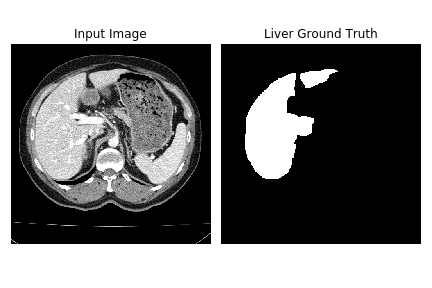

In [3]:
image_pair_filepaths = get_image_pair_filepaths(data_dir)
dataset = Chaos2DSegmentationDataset(image_pair_filepaths)
print(f'Number of image pairs {len(dataset)} = Number of images {len(dataset)*2}')
image, target = dataset[50]
print(f"""
    Input Image:
    \t Shape: {image.shape}
    \t Dtype: {image.dtype}
    \t Min and Max Values: [{image.min()}, {image.max()}]

    Target Image:
    \t Shape: {target.shape}
    \t Dtype: {target.dtype}
    \t Min and Max Values: [{target.min()}, {target.max()}]
""")

normalize = NormalizeInstance(1.0)
scaled_image = normalize(image)
create_canvas(scaled_image, target, title1='Input Image', title2='Liver Ground Truth')

# Filter for Slices that Contain Large Enough Livers and Create HDF5 File

In [3]:
hdf5_path = os.path.join(data_dir, 'train.hdf5')
hf = h5py.File(hdf5_path, 'w')
image_dset = hf.create_dataset('images', (1, 512, 512), maxshape=(None, 512, 512))
target_dset = hf.create_dataset('masks', (1, 512, 512), maxshape=(None, 512, 512))

i = 0
num_pixels = 4800
for image, target in tqdm(dataset):
    if np.sum(target == 1) < num_pixels:
        continue
        
    image_dset[i] = image
    target_dset[i] = target

    i += 1
    image_dset.resize((i+1, 512, 512))
    target_dset.resize((i+1, 512, 512))
hf.close()

100%|██████████| 2874/2874 [03:37<00:00, 13.21it/s]


In [4]:
hdf5_path = os.path.join(data_dir, 'train.hdf5')
hf = h5py.File(hdf5_path, 'r')
print(f'Number of Filtered Slices: {len(hf["images"])}')
hf.close()

Number of Filtered Slices: 2000


This is a rough guess of how large the liver needs to be:

4820


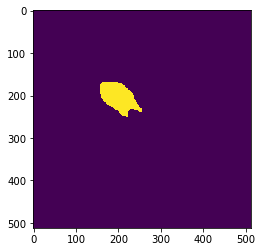

In [20]:
_, target = dataset[102]
print(np.sum(target == 1))
plt.imshow(target)

In [ ]:
image_filepaths = [pair[0] for pair in get_image_pair_filepaths(data_dir)[50:60]]

train_filepaths, val_filepaths = train_test_split(image_filepaths,
                                                  train_size=params['split_train_val'],
                                                  random_state=params['random_seed'],
                                                  shuffle=params["shuffle_data"])

train_images = np.asarray([pydicom.dcmread(fp).pixel_array for fp in train_filepaths])
train_targets = np.array([0] * len(train_images))

val_images = np.asarray([pydicom.dcmread(fp).pixel_array for fp in val_filepaths])
val_targets = np.array([0] * len(val_images))

# Augment Images per Volume

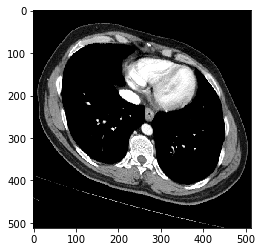

In [3]:
import math
class Shear(object):

    def __init__(self, 
                 shear, 
                 fill_mode='constant', 
                 fill_value=0., 
                 target_fill_mode='nearest', 
                 target_fill_value=0., 
                 lazy=False):
        """Shear an image with degrees (x, y)
        Arguments
        ---------
        shear : tuple(float)
            radian angles on the shear transform
        
        fill_mode : string in {'constant', 'nearest'}
            how to fill the empty space caused by the transform
        fill_value : float
            the value to fill the empty space with if fill_mode='constant'
        lazy    : boolean
            if true, perform the transform on the tensor and return the tensor
            if false, only create the affine transform matrix and return that
        """
        self.shear = shear
        self.fill_mode = fill_mode
        self.fill_value = fill_value
        self.target_fill_mode = target_fill_mode
        self.target_fill_value = target_fill_value
        self.lazy = lazy

    def __call__(self, x, y=None):
        shear = (self.shear[0]*math.pi/180, self.shear[1]*math.pi/180)
        shear_matrix = np.array([[1, -math.sin(shear[0]), 0],
                                 [0, math.cos(shear[1]), 0],
                                 [0, 0, 1]])
        if self.lazy:
            return shear_matrix
        else:
            x_transformed = torch.from_numpy(apply_transform(x.numpy(), 
                shear_matrix, fill_mode=self.fill_mode, fill_value=self.fill_value))
            if y:
                y_transformed = torch.from_numpy(apply_transform(y.numpy(), shear_matrix,
                fill_mode=self.target_fill_mode, fill_value=self.target_fill_value))
                return x_transformed, y_transformed
            else:
                return x_transformed
            

def transform_matrix_offset_center(matrix, x, y):
    """Apply offset to a transform matrix so that the image is
    transformed about the center of the image. 
    NOTE: This is a fairly simple operaion, so can easily be
    moved to full torch.
    Arguments
    ---------
    matrix : 3x3 matrix/array
    x : integer
        height dimension of image to be transformed
    y : integer
        width dimension of image to be transformed
    """
    o_x = float(x) / 2 + 0.5
    o_y = float(y) / 2 + 0.5
    offset_matrix = np.array([[1, 0, o_x], [0, 1, o_y], [0, 0, 1]])
    reset_matrix = np.array([[1, 0, -o_x], [0, 1, -o_y], [0, 0, 1]])
    transform_matrix = np.dot(np.dot(offset_matrix, matrix), reset_matrix)
    return transform_matrix

def apply_transform(x, transform, fill_mode='nearest', fill_value=0.):
    """Applies an affine transform to a 2D array, or to each channel of a 3D array.
    NOTE: this can and certainly should be moved to full torch operations.
    Arguments
    ---------
    x : np.ndarray
        array to transform. NOTE: array should be ordered CHW
    
    transform : 3x3 affine transform matrix
        matrix to apply
    """
    x = x.astype('float32')
    transform = transform_matrix_offset_center(transform, x.shape[1], x.shape[2])
    final_affine_matrix = transform[:2, :2]
    final_offset = transform[:2, 2]
    channel_images = [ndimage.interpolation.affine_transform(x_channel, final_affine_matrix,
            final_offset, order=0, mode=fill_mode, cval=fill_value) for x_channel in x]
    x = np.stack(channel_images, axis=0)
    return x

volumes = get_chaos_volumes(data_dir)
dicom = pydicom.dcmread(volumes[0][0][0])
image = extract_array_as_HU(dicom)
image = apply_ct_abdomen_filter(image)
transformed_image = ndimage.rotate(image, 15, reshape=False, cval=image.min())
# plt.imshow(transformed_image, cmap="gray")

# processed_image = KT.shear(torch.Tensor(image).unsqueeze(0), torch.Tensor([[0.15, 0.15]]))
shear = Shear((15, 15), fill_value=image.min())
processed_image = shear(torch.Tensor(image).unsqueeze(0))
plt.imshow(processed_image.squeeze().numpy(), cmap='gray')

In [4]:
dicom

(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0008) Image Type                          CS: ['ORIGINAL', 'PRIMARY', 'AXIAL', 'VOLUME']
(0008, 0012) Instance Creation Date              DA: ''
(0008, 0013) Instance Creation Time              TM: ''
(0008, 0016) SOP Class UID                       UI: CT Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.3.6.1.4.1.9590.100.1.2.280510459111334941500669771943535450335
(0008, 0020) Study Date                          DA: ''
(0008, 0021) Series Date                         DA: ''
(0008, 0022) Acquisition Date                    DA: ''
(0008, 0023) Content Date                        DA: ''
(0008, 0030) Study Time                          TM: '162238'
(0008, 0031) Series Time                         TM: '162826.510000'
(0008, 0032) Acquisition Time                    TM: '162826.510000'
(0008, 0033) Content Time                        TM: '163047.801375'
(0008, 0050) Accession Number                

In [7]:
volumes = get_chaos_volumes(data_dir)
hdf5_path = os.path.join(data_dir, 'train_augmented.hdf5')
hf = h5py.File(hdf5_path, 'w')
image_dset = hf.create_dataset('images', (1, 512, 512), maxshape=(None, 512, 512))
target_dset = hf.create_dataset('masks', (1, 512, 512), maxshape=(None, 512, 512))

i = 0
num_pixels = 4800
image_min = -135

for shear_angle in tqdm(range(-15, 16, 5)):
    
    shear_image = Shear((shear_angle, shear_angle), fill_value=image_min)
    shear_target = Shear((shear_angle, shear_angle), fill_value=0)
    
    for rot_angle in tqdm(range(-30, 31, 5), leave=False):
        
        for vol in tqdm(volumes, leave=False):
            
            for image_fp, target_fp in vol:

                target = np.asarray(Image.open(target_fp)).astype(np.uint8)
                if np.sum(target == 1) < num_pixels:
                    continue

                image = cv2.resize(image, (512, 512))
                target = cv2.resize(target, (512, 512))

                dicom = pydicom.dcmread(volumes[0][0][0])
                image = extract_array_as_HU(dicom)
                image = apply_ct_abdomen_filter(image)

                image = ndimage.rotate(image, rot_angle, reshape=False, cval=image.min())
                target = ndimage.rotate(target, rot_angle, reshape=False, cval=target.min())
                
                image = shear_image(torch.Tensor(image).unsqueeze(0)).squeeze().numpy()
                target = shear_target(torch.Tensor(target).unsqueeze(0)).squeeze().numpy()

                image_dset[i] = image
                target_dset[i] = target

                i += 1
                image_dset.resize((i+1, 512, 512))
                target_dset.resize((i+1, 512, 512))

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  5%|▌         | 1/20 [00:10<03:23, 10.70s/it]

 10%|█         | 2/20 [00:21<03:12, 10.72s/it]

 15%|█▌        | 3/20 [00:30<02:52, 10.13s/it]

 20%|██        | 4/20 [00:43<02:56, 11.00s/it]

 25%|██▌       | 5/20 [00:59<03:10, 12.68s/it]

 30%|███       | 6/20 [01:13<03:00, 12.90s/it]

 35%|███▌      | 7/20 [01:24<02:42, 12.50s/it]

 40%|████      | 8/20 [01:53<03:27, 17.30s/it]

 45%|████▌     | 9/20 [02:08<03:04, 16.76s/it]

 50%|█████     | 10/20 [02:36<03:20, 20.09s/it]

 55%|█████▌    | 11/20 [02:52<02:48, 18.75s/it]

 60%|██████    | 12/20 [03:15<02:40, 20.05s/it]

 65%|██████▌   | 13/20 [03:31<02:11, 18.86s/it]

 70%|███████   | 14/20 [04:00<02:10, 21.78s/it]

 75%|███████▌  | 15/20 [04:18<01:43, 20.70s/it]

 80%|████████  | 16/20 [04:41<01:26, 21.60s/it]

 85%|████████▌ | 17/20 [05:14<01:15, 25.00s/it]

 90%|█████████ | 18/20 [05:31<00:45, 22.55s/it]

 95%|█████████▌| 19/20 [05:46<00:20, 20.21s/it]

In [10]:
hf.close()

In [ ]:
hdf5_path = os.path.join(data_dir, 'train.hdf5')
hf = h5py.File(hdf5_path, 'w')
image_dset = hf.create_dataset('images', (1, 512, 512), maxshape=(None, 512, 512))
target_dset = hf.create_dataset('masks', (1, 512, 512), maxshape=(None, 512, 512))

i = 0
num_pixels = 4800
for image, target in tqdm(dataset):
    if np.sum(target == 1) < num_pixels:
        continue
    
    image_dset[i] = image
    target_dset[i] = target

    i += 1
    image_dset.resize((i+1, 512, 512))
    target_dset.resize((i+1, 512, 512))
hf.close()

# Image Transforms

In [3]:
hdf5_path = os.path.join(data_dir, 'train.hdf5')
hf = h5py.File(hdf5_path, 'r')
image_dset = hf['images']
target_dset = hf['masks']

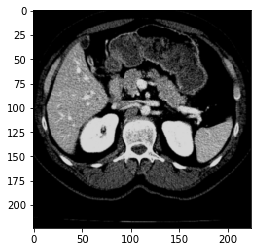

In [4]:
cc = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Grayscale(3),
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    K.CenterCrop((224, 224)),
    transforms.Lambda(lambda x: x.squeeze())
])
transformed_image = cc(image_dset[60])
# transfomed_images = cc(image_dset[10:11])
plt.imshow(transformed_image.permute(1, 2, 0).squeeze().numpy(), cmap="gray")

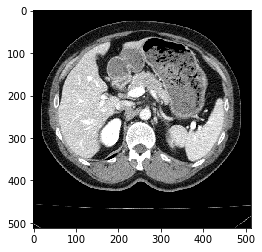

In [92]:
image = image_dset[50]
image = image.astype(np.float32)
t = transforms.ToTensor()(image)
# t = t.expand((3, 512, 512))
# t = NormalizeInstance(1.0)(t)
plt.imshow(t.permute(1,2,0).squeeze().numpy(), cmap="gray")

In [58]:
np.sum(image_dset[50] - np.array(Image.fromarray(image_dset[50]).convert('RGB').convert('L')))

-18874448.0

In [69]:
hf.close()

# Image Preprocessing for Raw DICOM Slices

We need to convert the raw pixel arrays to Hounsfield Units and apply a CT abdomen filter. This has been implemented in the Chaos2DSegmentationDataset

In [5]:
data_dir = os.path.join(data_dir)
image_filepaths = [pair[0] for pair in get_image_pair_filepaths(data_dir)[50:60]]

dicoms = [pydicom.dcmread(fp) for fp in image_filepaths]
images = [pydicom.dcmread(fp).pixel_array for fp in image_filepaths]

array, dicom = images[0], dicoms[0]

array = dicom.pixel_array
array = array.astype(np.int16)

intercept = dicom.RescaleIntercept
slope = dicom.RescaleSlope

if slope != 1:
    array = slope * array.astype(np.float64)
    array = array.astype(np.int16)

array += np.int16(intercept)

L = 40
W = 350
# image = images[0]
image[image < (L-(W//2))] = L - (W//2)
image[image > (L+(W//2))] = L + (W//2)

In [6]:
np.unique(array)

array([-1200, -1199, -1196, ...,  1201,  1204,  1218], dtype=int16)

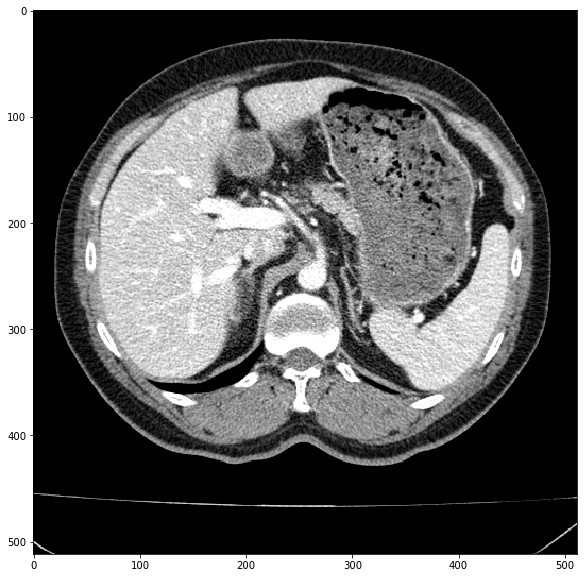

In [128]:
plt.figure(figsize=(10, 10))
plt.imshow(image, cmap="gray")